# ML_EndLS Part B: Feature selection and Modelling

Not all the features will correlate with the target variable. A PCA will be conducted, to attempt to visualise any possible linear separation of the target variable.

First, the feature data is re-introduced to the notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob

import IPython.display as ipd
from tqdm import tqdm
import librosa
import librosa.display

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import datetime

In [2]:
scaled_path = 'Data/Feature_csv_files/scaled_features_20250203.csv'
unscaled_path = 'Data/Feature_csv_files/unscaled_features_20250203.csv'
df_scaled = pd.read_csv(scaled_path, index_col=0)
df_unscaled = pd.read_csv(unscaled_path, index_col=0)

The features extracted from both scaled and unscaled recordings are available at this point. There would be pros and cons to using each for the modelling. On the one hand, scaling the data might lose information about the amplitude that could be useful. On the other hand, not scaling the data might risk that the amplitude information is an artefact of the specific recording device. On balance, the features generated using unscaled data will be used for modelling.

In [3]:
df_unscaled

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,power,pitch_mean,pitch_std,voiced_fr,indoor
0011.wav,8.729881,5.570604,5.673771,17.609569,14.151576,17.120781,40.064610,0.947703,0.940831,0.957733,...,4.177945e-03,1792.350750,2120.251193,0.012724,3746.777344,0.006082,236.538415,12.863792,0.081126,False
0031.wav,9.564665,5.875097,10.693469,16.676443,18.339468,14.172769,19.407950,0.740196,0.668494,0.688654,...,2.034151e-02,1396.604065,1692.695835,0.006456,2616.284180,0.004580,120.023654,17.732953,0.089530,True
0032.wav,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,1.000001,0.000000,0.009953,126.421030,14.868260,0.074341,True
0042.wav,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,1.000001,0.000000,0.005348,205.693875,95.328589,0.115842,False
0053.wav,18.896665,11.842226,11.783678,5.648594,6.064881,5.659297,42.261502,1.000000,0.937508,0.951040,...,2.700971e-03,2192.303770,2627.482305,0.035879,5243.334961,0.011254,128.362670,8.463564,0.062099,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2521.wav,0.224852,0.467714,0.644267,13.537627,4.008431,5.532543,10.759608,0.999574,0.994936,0.944478,...,7.016473e-09,2356.599333,2667.188508,1.000001,5211.035156,0.013448,128.570348,10.274455,0.051852,True
2528.wav,22.673634,7.613881,10.755005,8.603069,12.188140,11.496395,35.566616,0.880369,0.708090,0.789057,...,3.010719e-07,3331.840874,2815.299334,0.618529,6718.359375,0.010540,168.390676,15.999986,0.065432,True
2532.wav,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.735041,0.823202,0.713702,...,1.521968e-13,5481.824021,3862.202861,1.000001,10357.470703,0.006378,236.767369,30.845805,0.093207,True
2534.wav,3.302024,13.484016,22.976334,8.992814,19.636069,13.362332,45.877251,0.863709,0.795589,0.712931,...,1.019641e-04,2387.809566,2463.435878,0.039168,5415.600586,0.015292,0.000000,0.000000,0.000000,True


## 1 Train test split  

To avoid data leakage, the dataset will be split before any further analysis or feature extraction.

In [4]:
y = df_unscaled.pop('indoor')

In [5]:
X = np.array(df_unscaled)

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=94)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((288, 48), (72, 48), (288,), (72,))

## 2 Feature selection visualisation

### 2.1 Boxplots

Below are presented some representations of how well each feature correlates with the target variable.

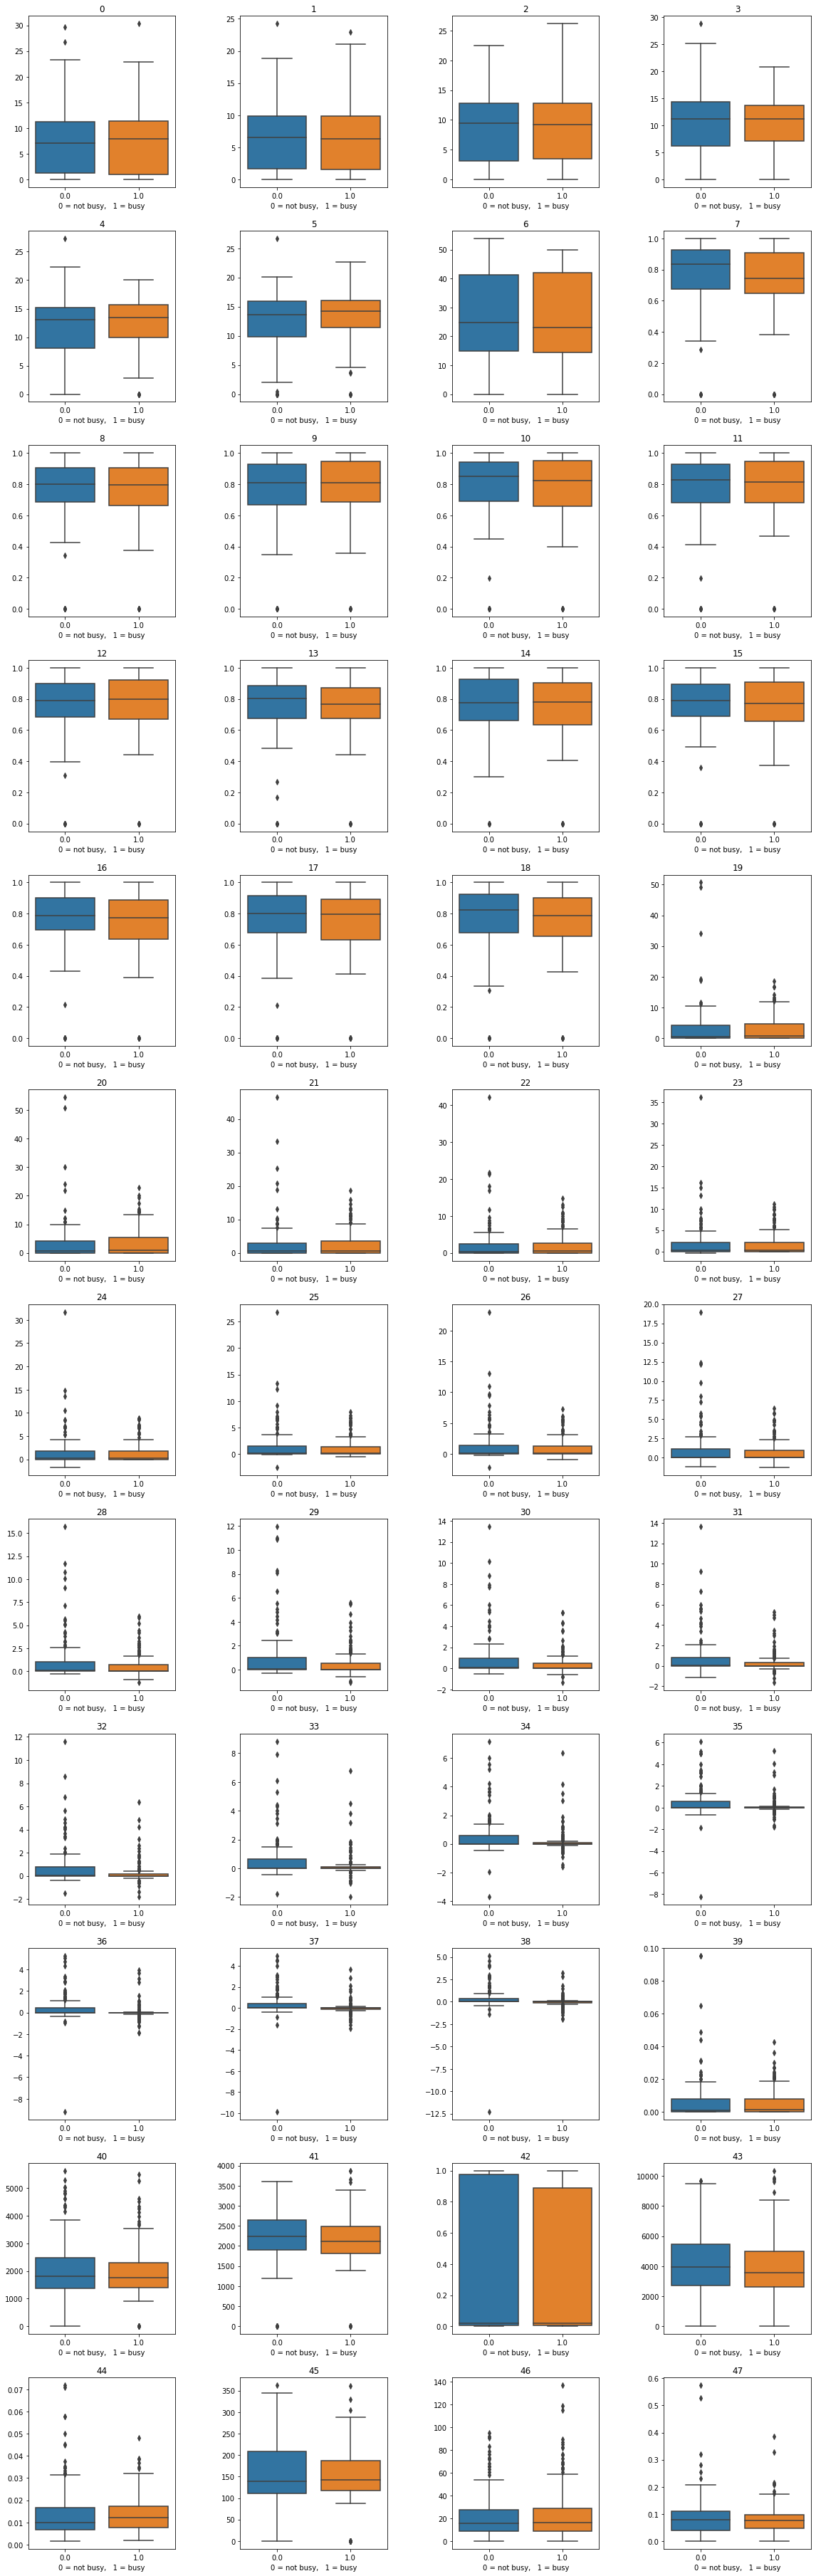

In [6]:
data = pd.DataFrame(np.column_stack((X_train, y_train)))
data = data.rename(columns={48:'y'})

fig, axs = plt.subplots(12, 4, figsize=(16,50))
fig.tight_layout(w_pad=6, h_pad=4)

for i in range(48):
    ax = axs[i//4, i%4]
    sns.boxplot(data=data, y=i, x='y', ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('0 = not busy,   1 = busy')
    ax.set_title(i)
plt.show()

And now with the outliers (fliers) hidden.

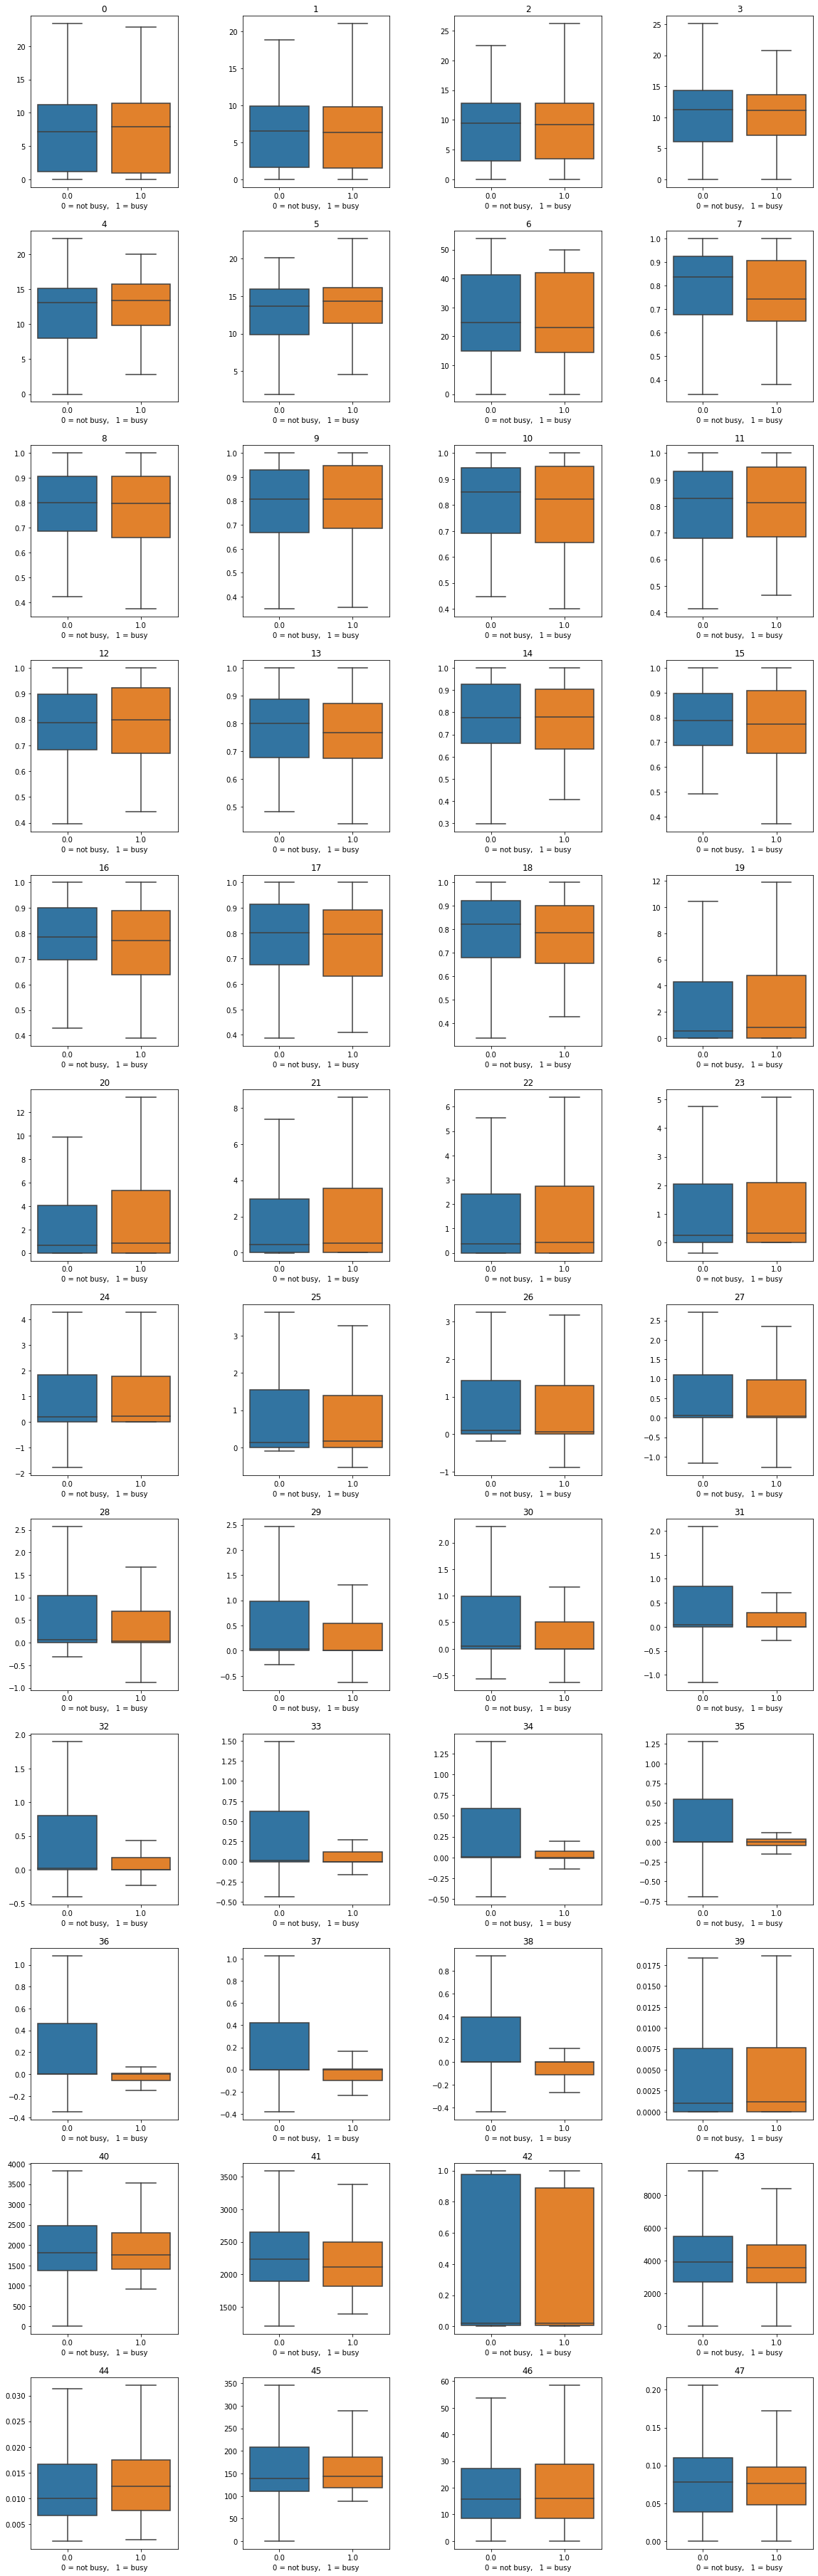

In [7]:
fig, axs = plt.subplots(12, 4, figsize=(16,50))
fig.tight_layout(w_pad=6, h_pad=4)

for i in range(48):
    ax = axs[i//4, i%4]
    sns.boxplot(data=data, y=i, x='y', ax=ax, showfliers=False)
    ax.set_ylabel('')
    ax.set_xlabel('0 = not busy,   1 = busy')
    ax.set_title(i)
plt.show()

With the fliers hidden, there appears to be some correlation between 34-38 and the target variable (as well as maybe 28-33, but less so). These correspond to 'MFCC' features. Therefore, modelling with only these features will be compared to modelling with all features.

In [8]:
X_train_1 = X_train[:, 34:39]

### 2.2 PCA  

A PCA with 2 components has been conducted on the reduced variables. This will produce a visualisation that is intended to indicate whether this transformation gives good linearly separable variables.

In [9]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X_train_1)
pca = PCA(n_components=2)
pca = pca.fit(X_scaled)
print(pca.explained_variance_ratio_)
pca = pca.transform(X_scaled)

[0.91420181 0.07964996]


In [10]:
df_pca = pd.DataFrame(data=pca, columns=['PC1', 'PC2'])

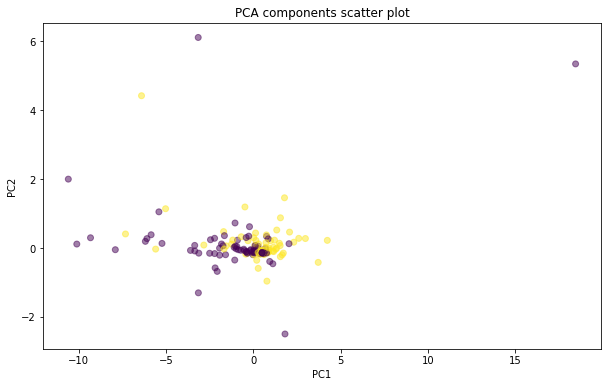

In [11]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()
p = ax.scatter(df_pca.PC1, df_pca.PC2,c=y_train.values, alpha=0.5)
ax.set_title('PCA components scatter plot')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

While there appears to be some separation, the majority of the points are clustered closely together, and therefore the PCA is unlikely to represent good separation for modelling. The two features of the PCA will not be compared with the full set of extracted features, as they are not expected to give better accuracy results.

# 3 Modelling

## 3.1 Model selection and validation  

### 3.1.1 Grid search to tune hyperparameters  

The best parameters for each model will be selected using sklearn's grid search function. The search will be scored and re-fitted based on accuracy.   

**For the SVM:**

In [12]:
# defining parameter range
param_grid = {
    'classifier__C': [0.1, 1, 10, 100, 1000],
    'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'classifier__kernel': ['rbf']
    }

pipe = Pipeline(steps = [('scaler', StandardScaler()),
                         ('classifier', svm.SVC())])

grid = GridSearchCV(pipe, param_grid, refit=True, verbose=0)

With the subset of features:

In [13]:
# fitting the model for grid search
grid.fit(X_train_1, y_train)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'classifier__C': 1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', SVC(C=1, gamma=0.1))])


With the full set of features:

In [14]:
# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'classifier__C': 1000, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', SVC(C=1000, gamma=0.01))])


**For the Random Forest:**

In [15]:
# defining parameter range
param_grid = {
    'classifier__max_depth': [2, 5, 10, 20, 50],
    'classifier__n_estimators': [10, 50, 100, 200, 500]
    }

pipe = Pipeline(steps = [('scaler', StandardScaler()),
                         ('classifier', RandomForestClassifier(
                             class_weight='balanced'))])

grid = GridSearchCV(pipe, param_grid, refit=True, verbose=0, cv=3,
                    scoring='balanced_accuracy')

# fitting the model for grid search
_ = grid.fit(X_train_1, y_train)

With the subset of features:

In [16]:
# fitting the model for grid search
grid.fit(X_train_1, y_train)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'classifier__max_depth': 2, 'classifier__n_estimators': 10}
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=2,
                                        n_estimators=10))])


With the full set of features:

In [17]:
# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'classifier__max_depth': 2, 'classifier__n_estimators': 10}
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=2,
                                        n_estimators=10))])


**For the Logistic Regression:**

In [18]:
# defining parameter range
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
    }

pipe = Pipeline(steps = [('scaler', StandardScaler()),
                         ('classifier', LogisticRegression(
                             solver='liblinear',
                             class_weight='balanced'))])

grid = GridSearchCV(pipe, param_grid, refit=True, verbose=0, cv=3,
                    scoring='balanced_accuracy')

# fitting the model for grid search
_ = grid.fit(X_train_1, y_train)

With the subset of features:

In [19]:
# fitting the model for grid search
grid.fit(X_train_1, y_train)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'classifier__C': 1, 'classifier__penalty': 'l2'}
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=1, class_weight='balanced',
                                    solver='liblinear'))])


With the full set of features:

In [20]:
# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

C:\Users\minor\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'classifier__C': 0.001, 'classifier__penalty': 'l2'}
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    solver='liblinear'))])


### 3.1.2 Cross-validation  

Several machine learning models are compared using cross-validation. 5 folds are used for each model

In [21]:
# Parameters for cross-validation
cv = 5

**For the subset of 8 features:**

In [22]:
classifiers = {'SVC' : svm.SVC(
                   C=1000,gamma=0.1),
               'Random Forest' : RandomForestClassifier(
                   max_depth=2, n_estimators=10),
               'Logistic Regression' : LogisticRegression(
                   solver='liblinear', C=0.1, penalty='l2')
               }

print('For the 8 selected variables:')
for key, clf in classifiers.items():
    pipe = Pipeline(steps = [('scaler', StandardScaler()), ('classifier', clf)])
    scores = cross_val_score(pipe, X_train_1, y_train, cv=cv)
    print('The cross-validation scores for', key, 'are:')
    print(scores)
    print(f'(mean = {scores.mean():.3f})')

For the 8 selected variables:
The cross-validation scores for SVC are:
[0.51724138 0.55172414 0.65517241 0.61403509 0.61403509]
(mean = 0.590)
The cross-validation scores for Random Forest are:
[0.60344828 0.62068966 0.62068966 0.57894737 0.45614035]
(mean = 0.576)
The cross-validation scores for Logistic Regression are:
[0.60344828 0.56896552 0.62068966 0.54385965 0.64912281]
(mean = 0.597)


**For the full set of 48 features:**

In [23]:
classifiers = {'SVC' : svm.SVC(
                   C=100,gamma=0.1),
               'Random Forest' : RandomForestClassifier(
                   max_depth=50, n_estimators=50),
               'Logistic Regression' : LogisticRegression(
                   solver='liblinear', C=0.001, penalty='l2')
               }

print('For the 48 extracted variables:')
for key, clf in classifiers.items():
    pipe = Pipeline(steps = [('scaler', StandardScaler()), ('classifier', clf)])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv)
    print('The cross-validation scores for', key, 'are:')
    print(scores)
    print(f'(mean = {scores.mean():.3f})')

For the 48 extracted variables:
The cross-validation scores for SVC are:
[0.51724138 0.56896552 0.70689655 0.45614035 0.59649123]
(mean = 0.569)
The cross-validation scores for Random Forest are:
[0.53448276 0.5862069  0.63793103 0.59649123 0.49122807]
(mean = 0.569)
The cross-validation scores for Logistic Regression are:
[0.56896552 0.51724138 0.60344828 0.52631579 0.49122807]
(mean = 0.541)


The Random Forest model, applied to the subset of features, appears to have marginally the best accuracy of around 63 %, and therefore will be tested and subsequently deployed.

## 3.2 Testing  

The selected model (Random Forest) will now be tested against the 20% separated data.

In [24]:
sc = StandardScaler().fit(X_train_1)
clf = RandomForestClassifier(max_depth=2, n_estimators=100)

X_train_scaled = sc.transform(X_train_1)
clf.fit(X_train_scaled,y_train)

X_test_1 = X_test[:, 34:39]
X_test_scaled = sc.transform(X_test_1)

yt_p = clf.predict(X_train_scaled)
yv_p = clf.predict(X_test_scaled)

print(f'Training Accuracy {np.mean(yt_p==y_train):.3f}')
print(f'Testing  Accuracy {np.mean(yv_p==y_test):.3f}')
print()
print('The confusion matrix for the training data is:')
print(confusion_matrix(y_train, yt_p))
print()
print('The confusion matrix for the test data is:')
print(confusion_matrix(y_test, yv_p))

Training Accuracy 0.646
Testing  Accuracy 0.681

The confusion matrix for the training data is:
[[134  20]
 [ 82  52]]

The confusion matrix for the test data is:
[[34  2]
 [21 15]]


The testing accuracy of 60 % is relatively low, but according to the confusion matrices, samples are not being exclusively classified one way or the other, and therefore there is some reliability in the model.

## 3.3 Training for deployment  

The time to extract the MFCC feature only is considerably less than all the features extracted in section 7.5. Therefore, below a function is defined to extract only those features. This will be run only once.  

First, the full set of files are pulled in again, and the MLEndLS_df dataframe is created.

In [25]:
sample_path = './Data/wav_files/*.wav'
files = glob.glob(sample_path)
MLEndLS_df = pd.read_csv('./Data/MLEndLSD.csv').set_index('Public filename') 
column_rename = {'Area' : 'area', 'Spot' : 'spot', 'In_Out' : 'in_out',
                 'Contributor' : 'Participant', 'Duration' : 'duration'}
MLEndLS_df = MLEndLS_df.rename(columns=column_rename)
MLEndLS_df.index.name = 'file_id'
MLEndLS_df.head()

,area,spot,in_out,Participant,duration
file_id,,,,,
0001.wav,british,street,outdoor,S151,9.59
0002.wav,kensington,dinosaur,indoor,S127,7.04
0003.wav,campus,square,outdoor,S18,8.85
0004.wav,kensington,hintze,indoor,S179,7.72
0005.wav,campus,square,outdoor,S176,11.42


In [26]:
def get_final(files,labels_file, scale_audio=False):
    X,y =[],[]
    for file in tqdm(files):
        fileID = file.split('\\')[-1]
        file_name = file.split('\\')[-1]
        yi = labels_file.loc[fileID]['in_out']=='indoor'

        fs = 22050 # if None, fs would be 22050
        x, fs = librosa.load(file,sr=fs)
        if scale_audio: x = x/np.max(np.abs(x))
        n_fft = 2048
        ft = np.abs(librosa.stft(x[:n_fft], hop_length=n_fft+1))
        mf = librosa.feature.mfcc(S=ft, sr=fs)

        xi = mf.T[0][15:20]

        X.append(xi)
        y.append(yi)

    return np.array(X),np.array(y)

# Code was run once, presented in the notebook for completeness.
X_f, y_f = get_final(files, labels_file=MLEndLS_df, scale_audio=False)

# Code was run once, presented in the notebook for completeness.
fileID = [file.split('\\')[-1] for file in files]
df_final = pd.DataFrame(X_f, index=fileID)
df_final = pd.DataFrame(X_f, index=fileID)
df_final['busy'] = y_f
df_final

100%|██████████████████████████████████████████████████████████████████████████████| 2552/2552 [01:06<00:00, 38.40it/s]


,0,1,2,3,4,busy
0001.wav,1.478282e+00,1.601212e+00,1.763647e+00,1.758820e+00,1.639498e+00,False
0002.wav,-2.414250e+00,-2.656078e+00,-2.803100e+00,-2.899581e+00,-2.888017e+00,True
0003.wav,1.280883e+00,1.126775e+00,1.143610e+00,1.052870e+00,9.945654e-01,False
0004.wav,-2.838835e-01,-3.124627e-01,-3.423039e-01,-3.224113e-01,-2.026944e-01,True
0005.wav,4.448469e-05,3.604768e-05,2.167258e-05,7.245800e-06,3.454333e-07,False
...,...,...,...,...,...,...
2548.wav,-2.258293e-05,-1.990189e-05,-1.192934e-05,-1.920622e-06,6.804710e-06,True
2549.wav,-9.574857e-02,-1.170341e-01,-1.767619e-01,-3.734183e-01,-4.107192e-01,True
2550.wav,1.401922e-01,1.440531e-01,1.460416e-01,1.344007e-01,1.220673e-01,True
2551.wav,-2.727566e-07,-1.384460e-08,1.957793e-07,5.271041e-07,7.004977e-07,True


In [27]:
# Code was run once, presented in the notebook for completeness.
df_final.to_csv('Data/Feature_csv_files/final_features.csv')

In [28]:
final_path = 'Data/Feature_csv_files/final_features_20250203.csv'
df_final = pd.read_csv(final_path, index_col=0)
df_final

y_final = df_final.pop('busy')

Below, the model is trained on the whole dataset, and can be deployed.

In [29]:
X_f = np.array(df_final)
X_final = StandardScaler().fit_transform(X_f)
model = RandomForestClassifier(max_depth=2, n_estimators=100)
model.fit(X_final, y_final)
y_p = model.predict(X_final)

print(f'Model Accuracy {np.mean(y_p==y_final):.3f}')
print()
print('The confusion matrix for the data is:')
print(confusion_matrix(y_final, y_p))

Model Accuracy 0.629

The confusion matrix for the data is:
[[1083  227]
 [ 719  523]]


# 4 Conclusions

The classifier seems to be moderately successful at identifying indoor vs. outdoor sounds, with a testing accuracy of 63 %.

Further areas for development could be:  
- Deeper understanding of extracted features (domain knowledge of sound analysis would be useful here).
- Different classification problems e.g. different areas, clustering participants.
- Improvement of accuracy of classification using the ROC.